# Kalorimetrie Küchentischversuch - Wärmekapazität eines Behälters

Author: Pascal Pohlenz

Datum: 22.11.2023

Gruppe: 93

## Forschungsfrage

Wie kann man die Wärmekapazität eines Gegenstandes messen und die zur Ermittlung der Wärmekapazität genutzten Hilfsmittel und Proben nach dem FAIR-Prinzip speichern ?

## Versuchsaufbau und Durchführung

<img src="figures/calorimetry.jpg">
Es werden zwei Gefäße mit einer abgewogenen Menge an Wasser befüllt. Das eine Gefäß mit warmen (ca. 60°C), das andere mit kaltem bzw. zimmerwarmen Wasser. Daraufhin werden in jedes Gefäß Temperatursensoren gegeben, welche mit Hilfe eines Codes die vorliegende Temperatur in eine hdf5-Datei speichern. Sobald der Code ausgeführt wurde, wird das warme Wasser zusammen mit dem Sensor in das Gefäß mit dem kalten Wasser "geschüttet" und umgerührt. Die Temperatur wird solange aufgezeichnet bis beide Sensoren eine (fast) gleiche Temperatur anzeigen.

## Versuchsauswertung

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
# If you plan to write functions in another module,
# you can use importlib.reload(module) to reload the module
# at the beginning of each cell in order to make the latest
# changes take effect without restart the kernel.
import importlib
from functions import m_json


# Use FST-Style, if you don't like it, you can safely delete this line.
plt.style.use("FST.mplstyle")

### Wärmekapazität eines Behälters

Hinweis: Nutzen Sie die Funktionen *get_ids_from_setup* und *get_json_entry* um auf Metadaten zuzugreifen. 

Sie sollten Ihr Programm zwischen TODO und DONE implementieren, und versuchen die Anweisung zu verfolgen. Das ist aber nicht erforderlich.


#### (i) Messdaten einlesen

Messdaten werden in das Notebook eingelesen.

In [35]:
hdf5_path = "data/data_heat_capacity.h5"

In [36]:
# Einlesen der Metadaten des Versuchsetups und einlesen der aufgezeichneten Temperaturen mit den zugehörigen Zeiten
ids = m_json.get_metadata_from_setup("data/heat_capacity/setup_heat_capacity.json")
with h5py.File(hdf5_path, 'r') as f:
    temp_hot_cup = np.array(f.get("RawData/1ee84919-ff67-68fc-a854-e2beea74d373/temperature"))
    time_hot_cup = np.array(f.get("RawData/1ee84919-ff67-68fc-a854-e2beea74d373/timestamp"))
    temp_cold_cup = np.array(f.get("RawData/1ee8491a-b1f8-6a10-a247-4e56289ecc9a/temperature"))
    time_cold_cup = np.array(f.get("RawData/1ee8491a-b1f8-6a10-a247-4e56289ecc9a/timestamp"))
    metadata = f.attrs
    metadata = {key: value for key, value in metadata.items()}    

{'all': {'names': ['group_info',
                   'raspberry_pi',
                   'temperature_coldcup',
                   'temperature_hotcup',
                   'probe_description',
                   'cold cup',
                   'hot cup',
                   'water heater',
                   'water'],
         'values': ['1ee84943-d884-6da0-9c3e-62cba276d436',
                    '1ee8493c-56b2-6175-a5c3-c779b519ae83',
                    '1ee8491a-b1f8-6a10-a247-4e56289ecc9a',
                    '1ee84919-ff67-68fc-a854-e2beea74d373',
                    '1ee87017-f9fd-66fa-b700-9be1c7295937',
                    '1ee87150-c6cc-67f9-9939-83d319720759',
                    '1ee87156-8688-6361-b3fd-101799b5c73c',
                    '1ee87158-8ea2-6750-8b7f-8a0ffc4f05a7',
                    '1ee8715b-f57f-674e-b1f7-00f660da53be']},
 'cup': {'names': ['cold cup', 'hot cup'],
         'values': ['1ee87150-c6cc-67f9-9939-83d319720759',
                    '1ee87156-8688-6361

#### (ii) Daten ploten

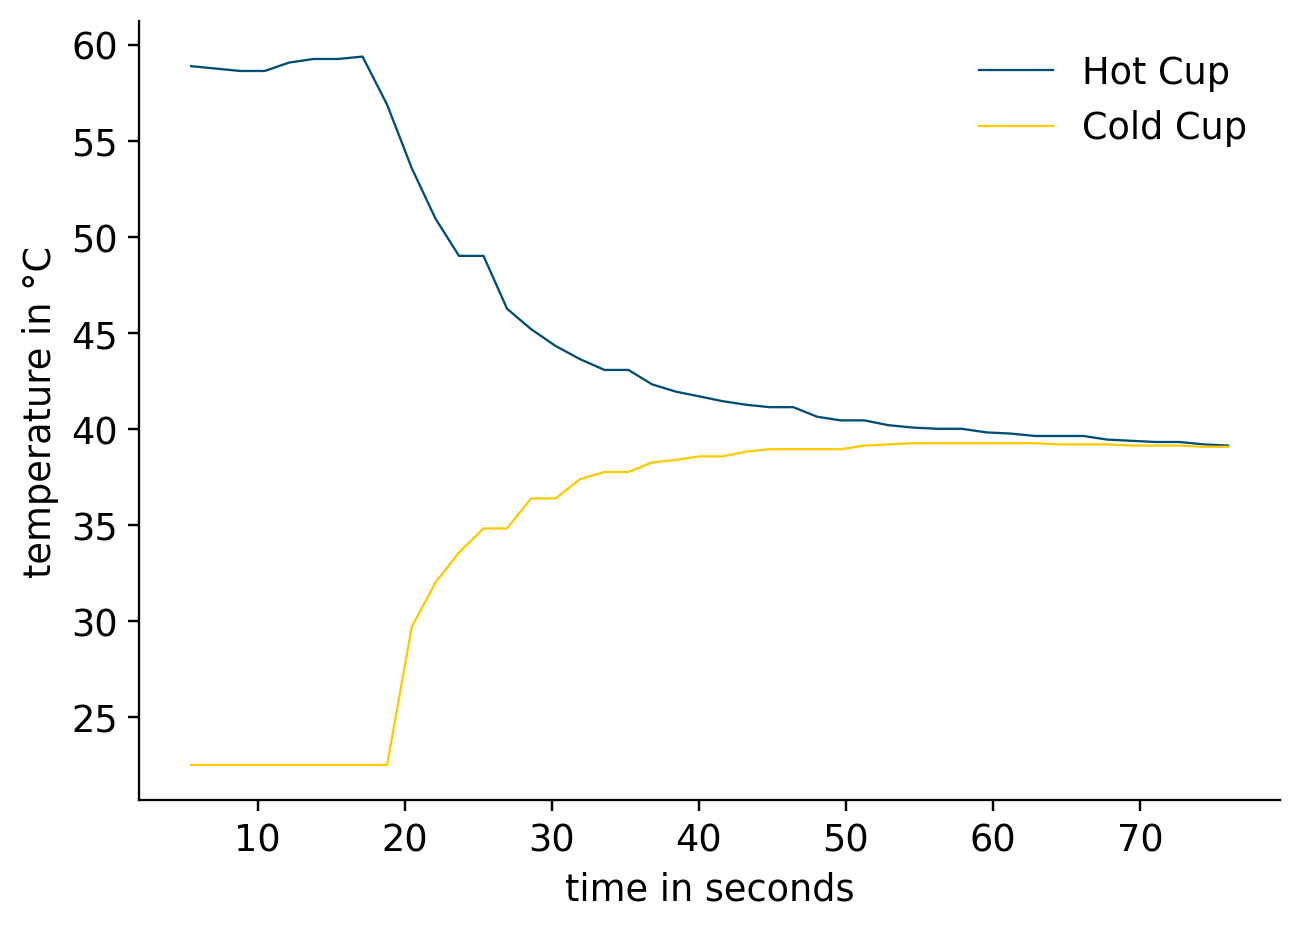

In [37]:
# Plotten der jeweiligen Temperaturen auf eine gemeinsame Zeitachse
plt.plot(time_hot_cup, temp_hot_cup, label="Hot Cup")
plt.plot(time_hot_cup, temp_cold_cup, label="Cold Cup")
plt.xlabel("time in seconds")
plt.ylabel("temperature in °C")
plt.legend()
plt.show()

#### (iii) Metadaten auslesen

Die notwendigen Metadaten für die Berechnung der Wärmekapazität wird ausgelesen.

In [38]:
# Heat capacity of Water
water_heat_capa = 4.18

# Auslesen der Wassermassen der jeweiligen Gefäße aus der JSON-Datei der Proben
cold_water_mass = float(m_json.get_json_entry("data/heat_capacity", "1ee87017-f9fd-66fa-b700-9be1c7295937", ["probe_1", "metadata", "weight in kg"]))
hot_water_mass = float(m_json.get_json_entry("data/heat_capacity", "1ee87017-f9fd-66fa-b700-9be1c7295937", ["probe_2", "metadata", "weight in kg"]))


#### (iV) Anfangs- und Endwert der Temperatur

In [39]:
# Definieren der Anfangstemperaturen des Wassers der jeweiligen Gefäße
t_1 = temp_cold_cup[0]
t_2 = temp_hot_cup[0]
# Definieren der Endtemperatur des Wassers indem der Mittelwert beider Temperaturangaben beider Sensoren am Ende berechnet wird
t_M = (temp_cold_cup[-1]+temp_hot_cup[-1])/2

#### (V) Wärmekapazität bestimmen
$$
C = \frac{m_{add}c_{w}(T_2-T_M)}{T_M - T_1} - m_{cup}c_{w}
$$
Dabei ist $m_{add}$ die Masse vom hinzugefügten Wasser, $T_2$ ist seine Temperatur. Die Masse vom Wasser im Behälter ist $m_{cup}$ und seine Temperatur ist $T_1$. Die Mischungstemperatur ist $T_M$. Die spezifische Wärmekapazität von Wasser ist $c_w$.

In [40]:
# Einsetzen der Metadaten und Temperaturen in die gegebene Gleichung
c = (hot_water_mass*water_heat_capa*(t_2-t_M))/(t_M-t_1)-cold_water_mass*water_heat_capa

#### (Vi) Ergebnis

In [41]:
# Ausgabe der berechneten Wärmekapazität des Gefäßes
print(f"Die Wärmekapazität des Kaloriemters beträgt etwa : {c} [kJ/(kg*K)]")

Die Wärmekapazität des Kaloriemters beträgt etwa : 0.14183661016949156 [kJ/(kg*K)]


## Diskussion

Analysieren Sie Ihre Ergebnisse aus wissenschaflticher Sicht. Berücksichtigen Sie dabei Ihre oben genannte Forschungsfrage.

Die berechnete spezifische Wärmekapazität des Gefäßes, hier eine Keramiktasse, ist in der Größenordnung fast vergleichbar mit Literaturwerten, welche beispielsweise für Porzellan eine spez. Wärmekapazität von 1,08 kJ/(kg*J) bei 95°C angeben (vgl. https://www.chemie.de/lexikon/Temperaturleitf%C3%A4higkeit.html, abgerufen am 22.11.2023).

Somit kann die Forschungsfrage mit einem Verweis auf die hier ausgeführten Codes und Methoden beantwortet werden. Es konnte mit einfachen Mitteln und ohne Laborumgebung eine spez. Wärmekapazität ermittelt werden, welche sich ca. um einen Faktor 7 von einem Literaturwert bei anderer Temperatur unterscheidet. Zusätzlich wurden die dabei genutzten bzw. erstellten Metadaten FAIR-erstellt und abgespeichert. Insbesondere dadurch, dass sie sowohl händisch als auch maschinell gelesen und bearbeitet werden können. 

## Fazit

Der Versuch hat mir gezeigt, dass verschiedene Funktionen wie sie hier benutzt wurden in der Erstellung aufwendig sind, aber sich im Verlauf der Zeit "bezahlt" machen, sodass ein einmaliger großer Aufwand für weitere Versuche den Arbeitsaufwand erheblich senkt. Zusätzlich habe ich die Erstellung und Bearbeitung von Dateien welche maschinell und händisch lesbar sind weiter gefestigt und neue Methoden kennengelernt, dies zu tun.